# Imports

In [1]:
import os

# import plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import math

# import machine learning libraries
import tensorflow as tf 
import tensorflow_io as tfio

#import audio processing libraries
from scipy.io.wavfile import write
from scipy.io.wavfile import read
import librosa.display
import librosa
from IPython.display import Audio

#import data processing libraries
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np

#import machine learning metrics
from sklearn.metrics import confusion_matrix

# Constants

In [2]:
SNORING_PATH = os.path.join('dataset', 'snoring')
NO_SNORING_PATH = os.path.join('dataset', 'nosnoring')

# sample files
SNORING_FILE = os.path.join(SNORING_PATH, '1_0.wav')
NO_SNORING_FILE = os.path.join(NO_SNORING_PATH, '0_0.wav')

# Helper Functions

In [3]:
def resample(waveform, sample_rate):
    waveform = waveform.numpy()
    sample_rate = sample_rate.numpy()
    return librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)

# Loads an audio file and converts it from 44KHz to 16KHz
def load_audio(filename):
    # if tf.is_tensor(filename):
    #     filename = filename.numpy().decode('utf-8')
    audio = tf.io.read_file(filename)
    waveform, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    # removes trailing silence in audio
    waveform = tf.squeeze(waveform, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # # convert the TensorFlow tensor to a numpy array
    # waveform_np = waveform.numpy()
    # # resamples the audio to 16KHz
    # waveform = librosa.resample(np.float32(waveform_np), orig_sr=sample_rate.numpy(), target_sr=16000)
    waveform = tf.py_function(resample, [waveform, sample_rate], tf.float32)
    return waveform


# converts symbolic tensors to concrete tensors
def load_audio_wrapper(filename, label):
    waveform = load_audio(filename)
    return waveform, label

# Verify the Data

In [4]:
snoring16k = load_audio(SNORING_FILE)
no_snoring16k = load_audio(NO_SNORING_FILE)

C:\Users\janon\AppData\Local\Temp\ipykernel_15800\715192526.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_audio = read(SNORING_FILE)


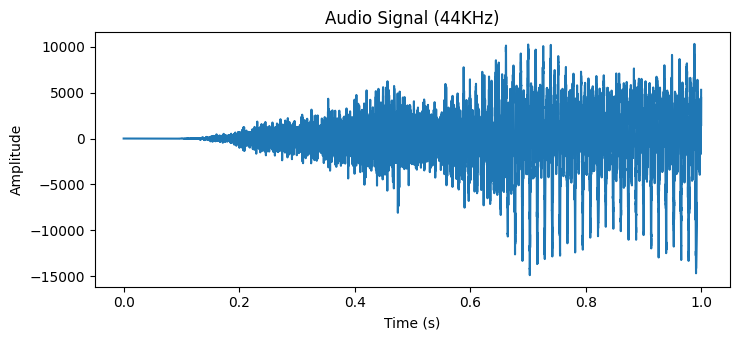

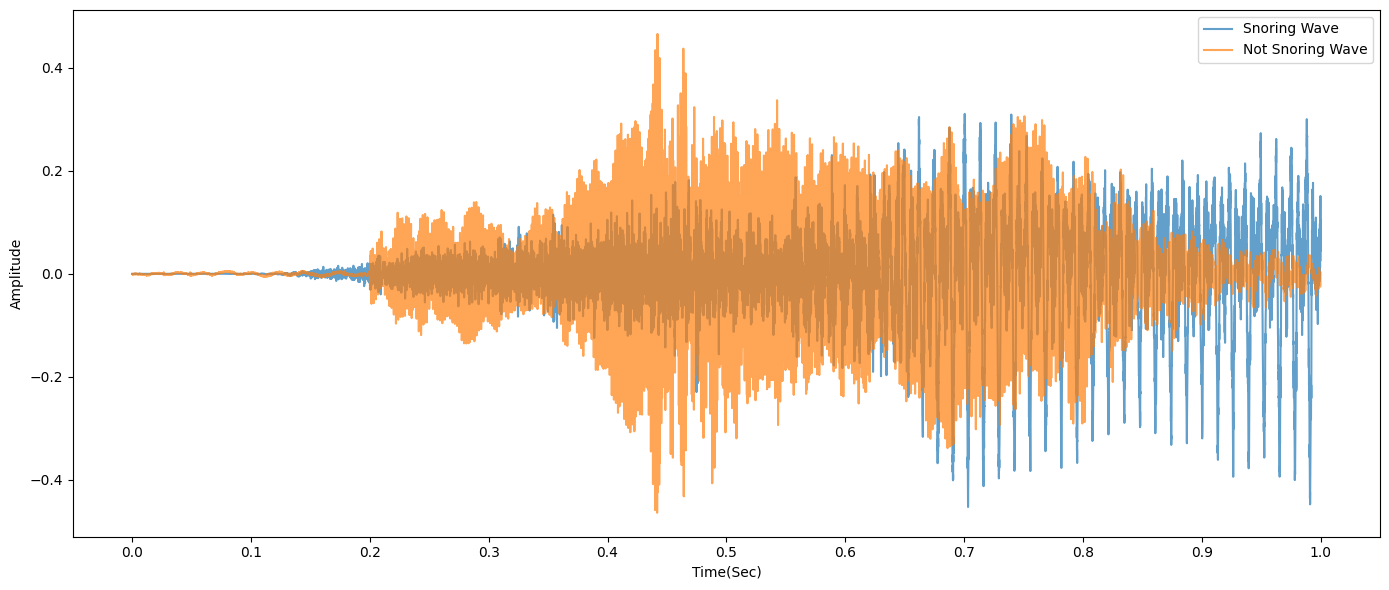

In [5]:
# plot audio file as 44KHz
plt.rcParams['figure.figsize'] = (7.5, 3.5)
plt.rcParams['figure.autolayout'] = True
input_audio = read(SNORING_FILE)
x = np.linspace(0, 1, num=len(input_audio[1]))

audio = input_audio[1]
plt.plot(x, audio)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Audio Signal (44KHz)')
plt.show()

# plot snoring and no-snoring audio file as 16KHz
x = np.linspace(0, 1, 16000)
plt.figure(figsize=(14, 6))
plt.plot(x,snoring16k, alpha=0.7)
plt.plot(x,no_snoring16k, alpha=0.7)
plt.xlabel('Time(Sec)')
plt.ylabel('Amplitude')
plt.legend(labels=['Snoring Wave', 'Not Snoring Wave'])
plt.xticks(np.linspace(0, 1, 11))
plt.show()

# Load Dataset

In [6]:
snoring_set = tf.data.Dataset.list_files(SNORING_PATH + '/*.wav')
no_snoring_set = tf.data.Dataset.list_files(NO_SNORING_PATH + '/*.wav')

# create labels for the dataset; 1 for snoring and 0 for no snoring
positives = tf.data.Dataset.zip((snoring_set, tf.data.Dataset.from_tensor_slices(tf.ones(len(snoring_set)))))
negatives = tf.data.Dataset.zip((no_snoring_set, tf.data.Dataset.from_tensor_slices(tf.zeros(len(no_snoring_set)))))
dataset = positives.concatenate(negatives)

# obtains the lengths of the audio files
lengths = []
for file in os.listdir(os.path.join(NO_SNORING_PATH)):
    tensor_wave = load_audio(os.path.join(NO_SNORING_PATH, file))
    lengths.append(len(tensor_wave))

# obtain the mean, min and max lengths of the audio files
# this value must be 16000 to ensure all audio files are the same length
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=16000>

In [7]:
# preprocesses the audio
def preprocessing(waveform, label):
    # takes only the first 16000 samples
    audio = waveform[:16000]
    # pads audio shorter than 16000 samples
    padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([padding, audio], 0)
    # obtains the short-time Fourier transform of the audio
    spectrogram = tf.signal.stft(audio, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    # adds an extra dimension to the spectrogram
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

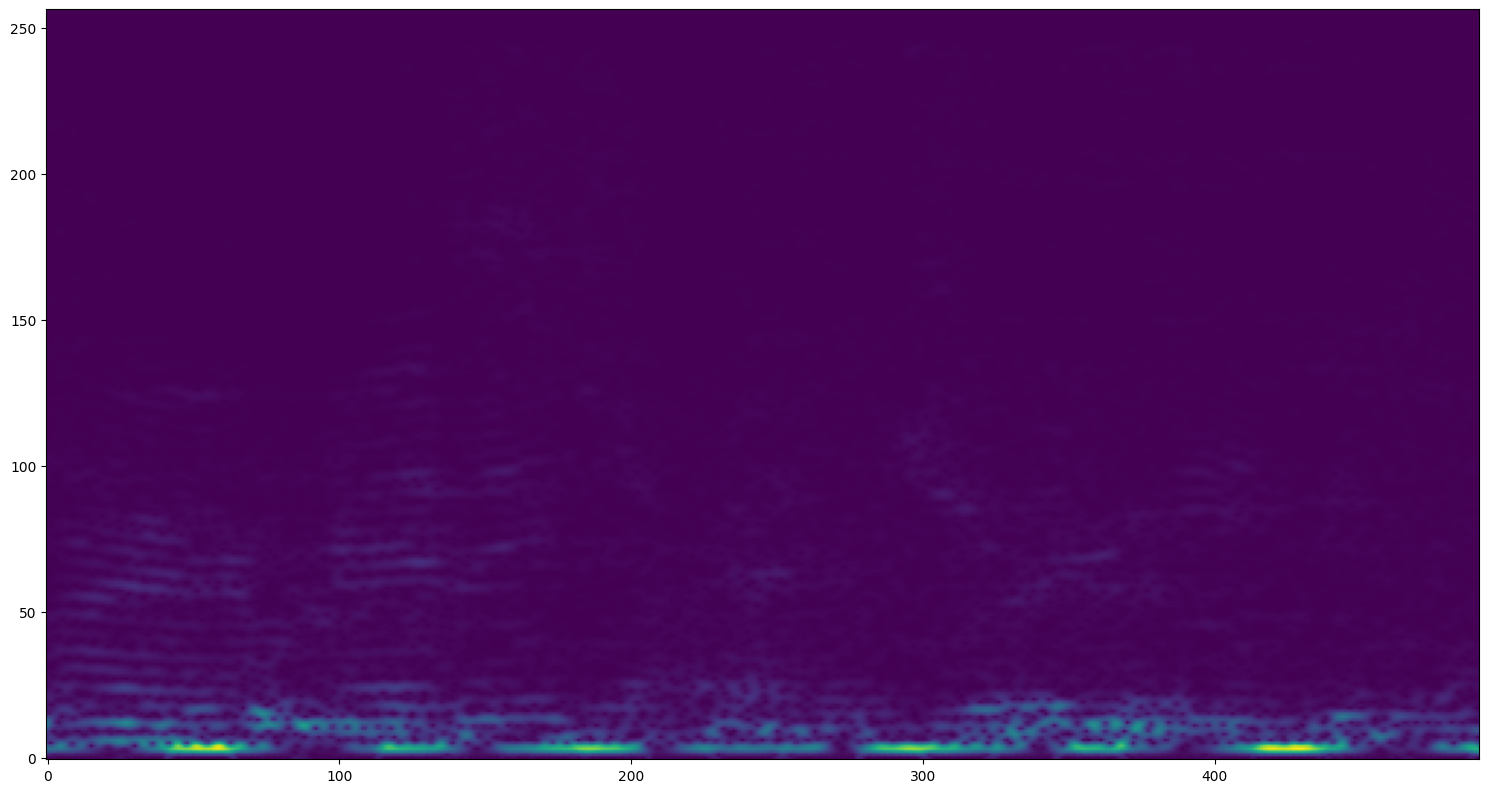

In [8]:
# shuffles the negatives dataset and load them into memory
filename, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

# load the audio from the filename
waveform, label = load_audio_wrapper(filename, label)

# test the preprocessing function and plot the spectrogram
spectrogram, label = preprocessing(waveform, label)

plt.figure(figsize=(15, 8))
plt.imshow(tf.transpose(spectrogram)[0])
plt.gca().invert_yaxis()
plt.show()

In [9]:
dataset.as_numpy_iterator().next()

dataset = dataset.map(load_audio_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.shuffle(1000)
dataset = dataset.batch(64)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

16

In [10]:
# calculates the size of the dataset for splitting into 70% training and 30% validation
total_size = len(list(dataset))
train_size = int(0.7 * total_size)
val_size = total_size - train_size

# shuffle the dataset before splitting
dataset = dataset.shuffle(total_size)

# split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# obtain the shape of the first batch of the training dataset
samples, labels = train_dataset.as_numpy_iterator().next()
samples.shape

(64, 491, 257, 1)

# Model Architecture